In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from node2vec import Node2Vec
import argparse

In [2]:
def read_dimacs_cnf(filename):
    clauses = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith("c"):
                continue
            if line.startswith("p cnf"):
                num_vars, num_clauses = map(int, line.strip().split()[2:])
            else:
                clause = list(map(int, line.strip().split()[:-1]))
                clauses.append(clause)
    return num_vars, clauses

In [3]:
def adding_to_graph(clauses):
    G = nx.Graph()
    for clause in clauses:
        for i in range(len(clause)):
            for j in range(i+1, len(clause)):
                G.add_edge(abs(clause[i]), abs(clause[j]))
    return G

def visualize_graph(G):
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=500)
    plt.show()

def generate_node_embeddings(G):
    node2vec = Node2Vec(G, dimensions=64, walk_length=40, num_walks=40, workers=4)
    print("Generating node embeddings...")
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    return model

In [4]:
def visualize_node_embeddings(model):
    node_ids = model.wv.index_to_key
    node_embeddings = [model.wv[str(node_id)] for node_id in node_ids]

    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(node_embeddings)

    plt.figure(figsize=(8, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
    for i, txt in enumerate(node_ids):
        plt.annotate(txt, (embeddings_2d[i, 0], embeddings_2d[i, 1]), xytext=(5, 2), textcoords='offset points')
    plt.title('Node Embeddings Visualization (2D)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

In [5]:
def visualize_node_embeddings_with_edges(model, graph):
    node_ids = list(graph.nodes)
    node_embeddings = [model.wv[str(node_id)] for node_id in node_ids]

    pca = PCA(n_components=3)
    embeddings_3d = pca.fit_transform(node_embeddings)

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], alpha=0.7)

    for edge in graph.edges():
        node1, node2 = edge
        idx1, idx2 = node_ids.index(node1), node_ids.index(node2)
        ax.plot([embeddings_3d[idx1, 0], embeddings_3d[idx2, 0]],
                [embeddings_3d[idx1, 1], embeddings_3d[idx2, 1]],
                [embeddings_3d[idx1, 2], embeddings_3d[idx2, 2]], color='gray', alpha=0.5)

    for i, txt in enumerate(node_ids):
        ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], txt, fontsize=8)

    ax.set_title('Node Embeddings Visualization (3D)')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.show()

In [6]:
def cluster_and_visualize_node_embeddings(model, graph, num_clusters=3):
    node_ids = list(graph.nodes)
    node_embeddings = [model.wv[str(node_id)] for node_id in node_ids]

    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(node_embeddings)

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings_2d)

    plt.figure(figsize=(10, 8))
    for i in range(num_clusters):
        cluster_points = embeddings_2d[cluster_labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')

    for i, txt in enumerate(node_ids):
        plt.annotate(txt, (embeddings_2d[i, 0], embeddings_2d[i, 1]), xytext=(2, 2), textcoords='offset points', fontsize=7)

    plt.title(f'Node Embeddings Clustering (K-means, {num_clusters} clusters)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()

In [7]:
# filename = "DIMACS_files/turbo_easy/example_2.cnf"
filename = "DIMACS_files/medium/unsat/Analiza1-AProVE07-08.cnf"

4614


Computing transition probabilities:   0%|          | 0/4614 [00:00<?, ?it/s]

Generating node embeddings...
Before visualization


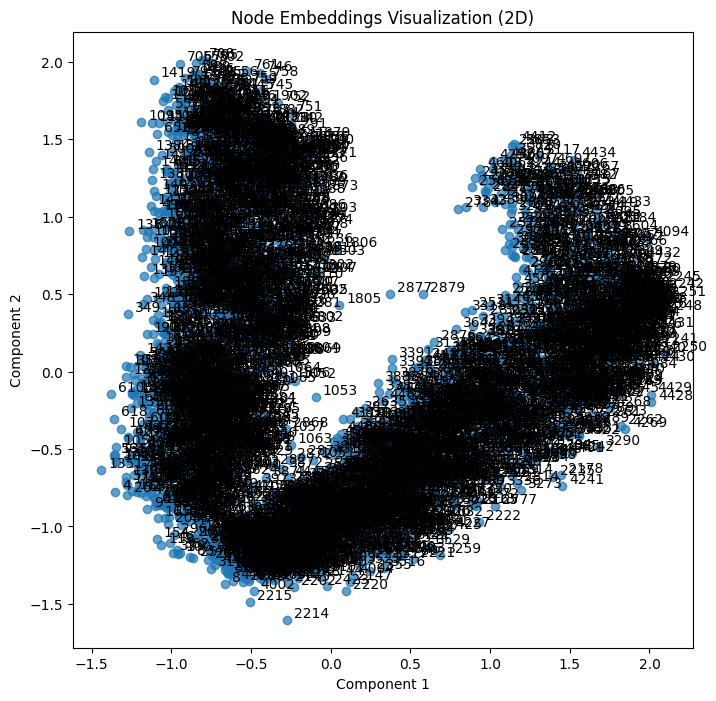

C:\Users\karol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


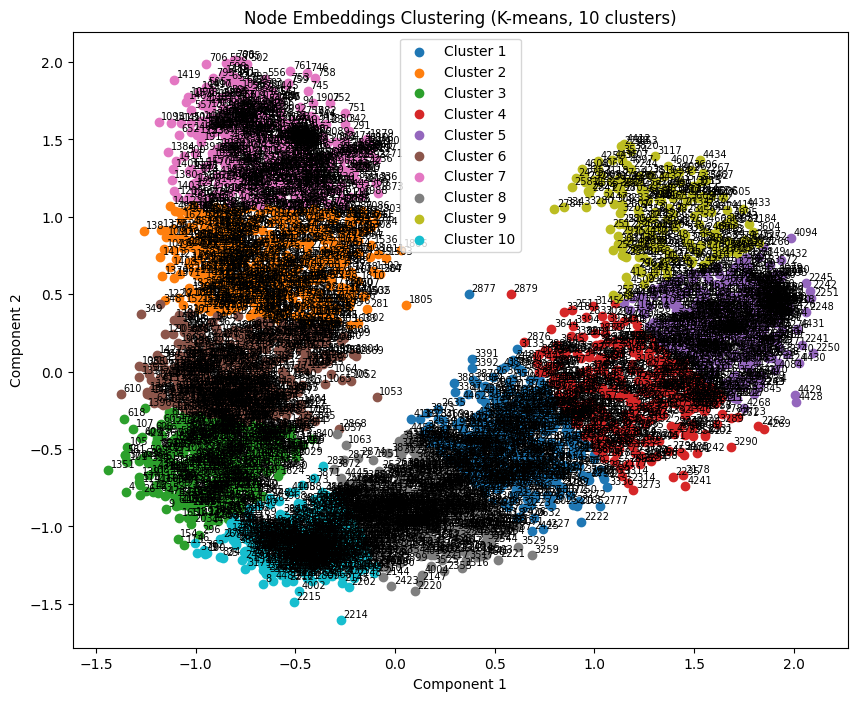

In [8]:
num_vars, clauses = read_dimacs_cnf(filename)
G = adding_to_graph(clauses)
print(num_vars)
node_embeddings_model = generate_node_embeddings(G)
print("Before visualization")
visualize_node_embeddings(node_embeddings_model)
cluster_and_visualize_node_embeddings(node_embeddings_model, G, num_clusters=10)